In [1]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import math
import pandas as pd
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

batch_size = 128
num_epochs = 100
image_size = 32
num_classes = 4
input_shape = (32, 32, 3)

train_dataset = "/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train"
val_dataset = "/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid"

In [4]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [5]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [8]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [9]:
cct_model = create_cct_model()
cct_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 32, 32, 3)   0           ['input_1[0][0]']                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      75456       ['data_augmentation[0][0]']      
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 64, 128)     0           ['cct_tokenizer[0][0]']          
 da)                                                                                          

In [10]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dataset,
                                                                 label_mode="categorical",
                                                                 batch_size=batch_size,
                                                                 image_size=(image_size,image_size))

test_data = tf.keras.preprocessing.image_dataset_from_directory(val_dataset,
                                                                label_mode="categorical",
                                                                batch_size=batch_size,
                                                                image_size=(image_size,image_size),
                                                                shuffle=False)

Found 1600 files belonging to 4 classes.
Found 400 files belonging to 4 classes.


In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001)

cct_model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

checkpoint_filepath = "best_model.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=15,
                                              verbose=1,
                                              mode='max')
callbacks_list = [checkpoint_callback, earlyStopping]

In [12]:
history = cct_model.fit(train_data,
                        validation_data=test_data,
                        epochs=num_epochs,
                        callbacks=callbacks_list)

Epoch 1/100
13/13 [==============================] - 197s 6s/step - loss: 1.8370 - accuracy: 0.2825 - val_loss: 1.4137 - val_accuracy: 0.3150
Epoch 2/100
13/13 [==============================] - 24s 918ms/step - loss: 1.3779 - accuracy: 0.3175 - val_loss: 1.3762 - val_accuracy: 0.3300
Epoch 3/100
13/13 [==============================] - 24s 920ms/step - loss: 1.3253 - accuracy: 0.3575 - val_loss: 1.3021 - val_accuracy: 0.4225
Epoch 4/100
13/13 [==============================] - 29s 1s/step - loss: 1.2630 - accuracy: 0.4275 - val_loss: 1.2943 - val_accuracy: 0.4175
Epoch 5/100
13/13 [==============================] - 24s 920ms/step - loss: 1.2124 - accuracy: 0.4825 - val_loss: 1.2178 - val_accuracy: 0.4600
Epoch 6/100
13/13 [==============================] - 22s 783ms/step - loss: 1.0991 - accuracy: 0.5231 - val_loss: 1.0540 - val_accuracy: 0.5325
Epoch 7/100
13/13 [==============================] - 24s 897ms/step - loss: 1.0116 - accuracy: 0.5731 - val_loss: 1.0614 - val_accuracy: 0.53

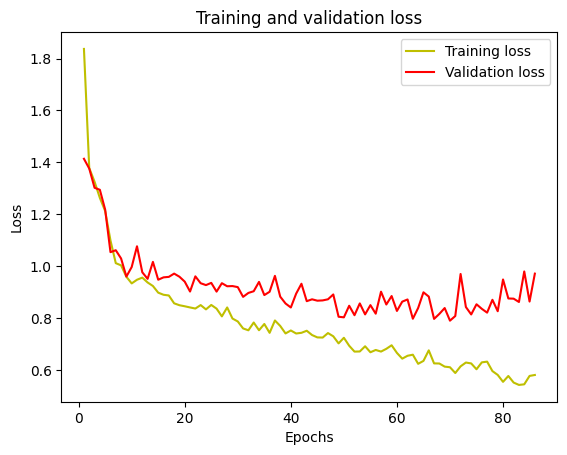

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

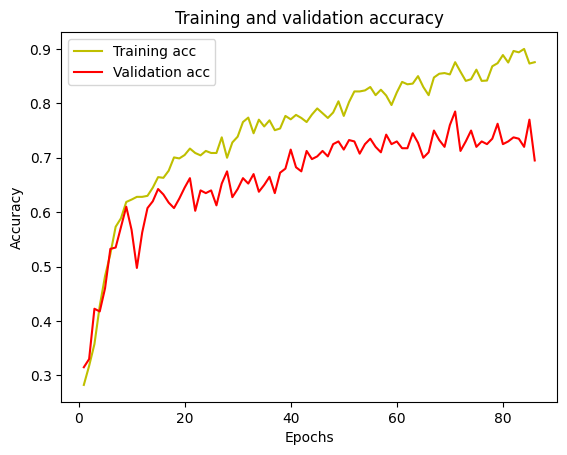

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [15]:
cct_model.load_weights('/content/best_model.h5')
_, accuracy = cct_model.evaluate(test_data)
print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

4/4 [==============================] - 4s 1s/step - loss: 0.8080 - accuracy: 0.7850
Validation accuracy: 78.5%


In [16]:
pred_probs = cct_model.predict(test_data, verbose=1)

4/4 [==============================] - 5s 1s/step


In [17]:
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [18]:
# custom function to compute performance metrics
def matrix_metrix(real_values,pred_values,beta):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Kappa = 2 * (TP * TN - FN * FP) / (TP * FN + TP * FP + 2 * TP * TN + FN**2 + FN * TN + FP**2 + FP * TN)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    Recall     = round( TP / (TP+FN),4 )
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Recall','F1','MCC','Kappa'],
                            'Value':[TP,TN,FP,FN,Accuracy,Precision,Recall,F1,MCC,Kappa]})
    return (mat_met)

In [19]:
# print all metrics

mat_met = matrix_metrix(y_labels,
                        pred_classes,
                        beta=0.4)
print (mat_met)

      Metric      Value
0         TP  98.000000
1         TN  85.000000
2         FP   2.000000
3         FN   2.000000
4   Accuracy   0.978600
5  Precision   0.980000
6     Recall   0.980000
7         F1   0.980000
8        MCC   0.957000
9      Kappa   0.957011


In [20]:
import seaborn as sns
cnf_matrix = confusion_matrix(y_labels,
                              pred_classes)

TP = cnf_matrix[0, 0]
TN = cnf_matrix[1:, 1:].sum()
FP = cnf_matrix[0, 1:].sum()
FN = cnf_matrix[1:, 0].sum()

Population = TN+FN+TP+FP
spesificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)
print("Spesificity:", spesificity)
print("Sensitivity:", sensitivity)

True Positives: 85
False Positives: 15
True Negatives: 285
False Negatives: 15
Spesificity: 0.95
Sensitivity: 0.85


In [21]:
# print the confusion matrix
target_names = ['amd', 'cataract', 'diabetes', 'normal']
print(classification_report(y_labels,
                            pred_classes,
                            target_names=target_names, digits=4))

              precision    recall  f1-score   support

         amd     0.8500    0.8500    0.8500       100
    cataract     0.9703    0.9800    0.9751       100
    diabetes     0.6769    0.4400    0.5333       100
      normal     0.6493    0.8700    0.7436       100

    accuracy                         0.7850       400
   macro avg     0.7866    0.7850    0.7755       400
weighted avg     0.7866    0.7850    0.7755       400



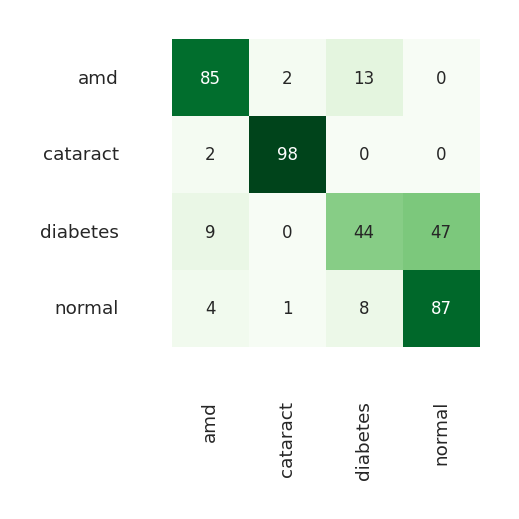

In [22]:
# Compute confusion matrix
import seaborn as sns
cnf_matrix = confusion_matrix(y_labels,
                              pred_classes)
np.set_printoptions(precision=5)

x_axis_labels = ['amd', 'cataract', 'diabetes', 'normal']
y_axis_labels = ['amd', 'cataract', 'diabetes', 'normal']
plt.figure(figsize=(1,1), dpi=400)
sns.set(font_scale=0.3)
b = sns.heatmap(cnf_matrix, annot=True, square = True,
            cbar=False, cmap='Greens',
            annot_kws={'size': 3},
            fmt='g',
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels)